# 💖 Hybrid Quantum–Classical Neural Network: Cleveland Heart Disease Analysis

This notebook implements a **hybrid quantum-classical model** combining a **quantum neural network (QNN)** built with Qiskit and a classical neural layer in PyTorch.  
The goal is to classify clinical samples from the **UCI Cleveland Heart Disease dataset** (8 selected clinical features) to predict the presence of heart disease (Binary Classification).

### ❓ Why Hybrid?
Hybrid QNNs leverage quantum circuits as **trainable feature extractors** that map data into high-dimensional Hilbert spaces, followed by classical layers for decision-making. This architecture allows us to explore the expressivity of quantum entanglement while retaining classical optimization efficiency.

### 🛠️ Experimental Setup
Before analysis, we:
- Set up the environment (**PyTorch, Qiskit, scikit-learn, Matplotlib**).  
- Preprocess the **Cleveland dataset** (normalization, median imputation) and prepare tensors for quantum encoding.  
- Build **8-qubit quantum circuits** using `RY` (and optional `RZ`) encoding and variational layers.  
- Construct the **QNN** using `EstimatorQNN` and integrate it into the `HybridModel`.  

---

## 📊 Analysis Roadmap & Evaluation Metrics

This notebook is structured to rigorously evaluate the "explainability," performance, and stability of the hybrid model through the following comprehensive modules:

1. **Baseline Performance & Training Dynamics**
   * *Is the model learning effectively?*
   * **Training Curves:** Train loss and accuracy comparison over epochs.
   * **Test Metrics:** Test accuracy, Confusion Matrix, and full classification report (Precision, Recall, F1, Support).
   * **Stability:** Mean accuracy $\pm$ standard deviation across multiple random seeds.

2. **Global Feature Importance**
   * *Which features matter most across the entire dataset?*
   * **Global Saliency:** Saliency maps + Average Feature Saliency.
   * **Sensitivity:** Average sensitivity analysis.
   * **Consistency:** Feature importance stability across seeds and Saliency Rank Stability.

3. **Local Attribution Methods**
   * *How do we explain individual predictions?*
   * **Grad × Input:** Normalized gradient-weighted input analysis.
   * **Integrated Gradients:** Path-integral based attribution (normalized).
   * **SmoothGrad:** Noise-averaged gradient sampling for cleaner explanations.

4. **Faithfulness & Causality Tests**
   * *Do the explanations truthfully reflect the model's logic?*
   * **Deletion Metric:** Measuring performance drop when "important" features are removed.
   * **Occlusion $\Delta$-Loss:** Impact of masking specific features on the loss function.
   * **Minimum Efficacy:** The smallest subset of features required to maintain the prediction.
   * **Overreliance Risk:** Detecting if the model relies too heavily on potential artifacts.

5. **Robustness & Stability of Explanations**
   * *Are the explanations fragile?*
   * **Noise Sensitivity:** How much explanations change with slight input perturbations.
   * **Saliency Entropy:** Measuring the disorder/complexity of the saliency distribution.
   * **Saliency Sparseness:** Evaluating how focused (sparse) the explanations are.

6. **Model Behavior & Manifold Visualization**
   * *How does the model represent the data?*
   * **PCA:** Dimensionality reduction of model embeddings/outputs.
   * **Decision Surface:** Visualizing decision boundaries using the top-2 salient features.
   * **Partial Dependence:** Analyzing the marginal effect of features on the predicted outcome.

7. **Parameter & Structural Sensitivity**
   * *Which components of the quantum circuit drive predictions?*
   * **Parameter Sensitivity:** Analyzing how changes in trainable parameters $\theta$ affect the output.
   * **Cumulative $\Delta$-Loss:** Loss impact accumulated per layer/operation.
   * **Gate Knock-Out:** Ablation studies removing specific quantum gates to test structural importance.

8. **Statistical Verification**
   * *Are the observed differences statistically significant?*
   * **Wilcoxon Signed-Rank Test:** Non-parametric statistical comparison between models or encoding schemes.
---

## ⚛️ Technologies Used
- **Qiskit Machine Learning**: `EstimatorV2`, `EstimatorQNN`, `TorchConnector`  
- **PyTorch**: `nn.Module`, `BCEWithLogitsLoss`, `Adam` optimizer  
- **scikit-learn**: `StandardScaler`, `PCA`, `classification_report`  
- **AerSimulator**: High-performance local quantum simulation  

*Part of the QAMP Project: “QNNs — Saliency & Sensitivity Kit”*

## 🛠️ Experimental Setup

### 🧩 Data and PyTorch Setup

In this section, we initialize the environment by importing the core libraries necessary for building, training, and validating our hybrid model.

* **PyTorch (`torch`)**: Our primary framework for building neural network architectures and managing tensors.
* **scikit-learn**: Utilized for the **Iris dataset**, feature scaling via `StandardScaler`, and robust evaluation metrics like ROC-AUC and Confusion Matrices.
* **SciPy**: Provides the `wilcoxon` test for performing non-parametric statistical comparisons between model versions.
* **Data Handling & Viz**: **Pandas** and **NumPy** manage data structures, while **Matplotlib** handles the visual analytics of our training progress.

In [25]:
# ===== 1. Core PyTorch Modules =====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ===== 2. Machine Learning Utilities (scikit-learn) =====
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer

# ===== 3. Statistical Analysis =====
from scipy.stats import wilcoxon

# ===== 4. Data Handling & Visualization =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### ⚛️ Quantum Components (Qiskit Setup)

Here we import Qiskit Machine Learning modules to build and simulate a quantum neural network (QNN). These components allow us to bridge quantum circuits with classical deep learning workflows.

* **Quantum Circuit Design**: We use `QuantumCircuit` and `Parameter` to build parameterized circuits that act as trainable quantum layers.
* **Execution & Simulation**: `AerSimulator` provides local simulation, while `EstimatorV2` (the modern primitive) handles the evaluation of circuit observables.
* **PyTorch Integration**: The `TorchConnector` is the crucial bridge, allowing a Qiskit QNN to behave like a standard `nn.Module` in PyTorch.
* **Gradient Computation**: `ParamShiftEstimatorGradient` implements the parameter-shift rule, enabling analytic gradients for quantum hardware.

In [16]:
# ===== 5. Qiskit Machine Learning & Quantum Core =====
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Quantum Neural Network & PyTorch Integration
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

# Simulation & Runtime
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2

### 🎲 Reproducibility Setup

To ensure consistent and comparable results across runs, we fix all random seeds used by **PyTorch** and **NumPy**.  
This guarantees that data shuffling, weight initialization, and stochastic processes behave deterministically.

In [17]:
# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### ⚙️ Training Hyperparameters

We define the key parameters that govern model training and encoding complexity.  
These values control the learning process, dataset split, and model configuration for both plain and richer quantum encodings.

In [18]:
# ===== Experiment Configuration =====
TEST_SIZE = 0.2
BATCH_SIZE = 8
QUBIT_COUNT = 8
USE_RICHER_ENCODING = True      # Toggle Rz gates for richer encoding
LEARNING_RATE = 1e-2
EPOCHS = 20
LOG_INTERVAL = 1                # Set to None to disable logging
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
TOP_8_FEATS = ["thal", "cp", "ca", "exang", "oldpeak", "chol", "thalach", "slope"]
UCI_COLS = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

### 📂 File Path Configuration

All models and evaluation metrics are saved in dedicated directories for each encoding variant.  
Separating these paths ensures clear experiment tracking and easy reproducibility when switching between configurations.

In [19]:
# ===== File Paths =====
PLAIN_ENCODING_MODEL_PATH = "../../models/hybrid/cleveland/plain_encoding/hybrid_model_plain_encoding.pt"
RICH_ENCODING_MODEL_PATH  = "../../models/hybrid/cleveland/rich_encoding/hybrid_model_rich_encoding.pt"

PLAIN_ENCODING_METRICS_PATH = "../../metrics/hybrid/cleveland/plain_encoding/metrics_plain_encoding"
RICH_ENCODING_METRICS_PATH  = "../../metrics/hybrid/cleveland/rich_encoding/metrics_rich_encoding"

## ❤️ Data Preprocessing - Cleveland Heart Disease Dataset

In this section, we load and prepare the **UCI Cleveland Heart Disease dataset** for our hybrid quantum-classical pipeline. This dataset is used to predict the presence of heart disease based on clinical features.

### Preprocessing Workflow:
1.  **Data Loading & Cleaning**: We fetch the dataset from the UCI repository, handle missing values (marked as `?`) using **Median Imputation**, and transform the multi-class diagnosis into a **Binary Classification** task (0 = Healthy, 1 = Disease).
2.  **Feature Selection**: We focus on the **Top 8 Features** most relevant to cardiovascular diagnosis to optimize the quantum circuit's dimensionality.
3.  **Standardization**: Features are scaled to zero mean and unit variance using `StandardScaler`.
4.  **Quantum Domain Mapping**: To ensure compatibility with quantum rotation gates (like $RX$ or $RY$), we rescale the standardized features to the range $[0, \pi]$.
5.  **PyTorch Integration**: Data is split into training and testing sets, converted into **Float32 Tensors**, and wrapped in a `DataLoader` for efficient batch processing.

In [20]:
# Load UCI dataset
def load_cleveland_uci():
    df = pd.read_csv(UCI_URL, header=None, names=UCI_COLS, na_values="?")
    y = (df["num"].astype(float) > 0).astype(int).to_numpy()
    
    X_df = df[TOP_8_FEATS].apply(pd.to_numeric, errors="coerce")  
    
    X_num = SimpleImputer(strategy="median").fit_transform(X_df)
    feature_cols = X_df.columns.tolist()
    return X_num.astype(np.float64), y.astype(int), feature_cols

# Load dataset
X, y, feature_cols = load_cleveland_uci()

# Normalize features
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Scale to [0, pi] range for quantum encoding
X_scaled = np.pi * (X_scaled / (np.max(np.abs(X_scaled), axis=0, keepdims=True) + 1e-9))

# Train/test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) 
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

# Create dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## ⚛️ Quantum Circuit Construction

This section defines the **parameterized quantum circuit (PQC)** that forms the quantum core of the hybrid model. The circuit is designed to compress the 8 clinical features of the Cleveland Heart Disease dataset into a single quantum prediction.

### 🧠 Circuit Structure
- **Qubits:** The circuit uses **8 qubits**, corresponding to the 8 input features.
- **Classical Encoding (`x_params`):** Features are embedded via `RY` rotations. If `use_richer_encoding` is enabled, an additional `RZ` rotation is applied to each qubit to increase the dimensionality of the quantum state.
- **Trainable Parameters (`theta_params`):** Two variational layers of trainable `RY` rotations allow the model to learn optimal weights.
- **Entanglement:** Linear entanglement is achieved using `CX` (CNOT) gates between adjacent qubits to capture feature correlations.

### 🔗 Circuit Workflow
1. **Encoding Layer:** Clinical features are mapped to quantum states ($RY$ + optional $RZ$).
2. **Variational Layer 1:** First set of trainable $RY(\theta)$ rotations followed by linear $CX$ entanglement.
3. **Variational Layer 2:** Second set of trainable $RY(\theta)$ rotations followed by a final entanglement layer.
4. **Measurement (Single Output):** The circuit defines a single **Pauli-Z observable** targeting Qubit 0 (`II...IZ`). By measuring this specific expectation value, the entire 8-qubit state is collapsed into a **single scalar output**, which is then fed into the classical binary classifier.

In [21]:
def build_quantum_circuit(use_richer_encoding=True):
    qc = QuantumCircuit(QUBIT_COUNT)

    # Parameters used for encoding classical features into qubits
    x_params = [Parameter(f'x{i}') for i in range(QUBIT_COUNT)]

    # Trainable parameters for the variational layers (two layers)
    theta_params = [Parameter(f'theta{i}_1') for i in range(QUBIT_COUNT)] + \
                   [Parameter(f'theta{i}_2') for i in range(QUBIT_COUNT)]

    # Layer 1: Input encoding + variational
    for i in range(QUBIT_COUNT):
        qc.ry(x_params[i], i)      # Encode feature i as rotation around Y-axis
        if use_richer_encoding:
            qc.rz(x_params[i], i)  # Encode feature i as rotation around Z-axis for richer representation

    for i in range(QUBIT_COUNT):
        qc.ry(theta_params[i], i)  # First layer of trainable rotations

    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)            # Linear entanglement between qubits with CNOT gates

    # Layer 2: Variational only
    for i in range(QUBIT_COUNT, 2 * QUBIT_COUNT):
        qc.ry(theta_params[i], i - QUBIT_COUNT)  # Second layer of trainable rotations
    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)                          # Another layer of linear entanglement

    # Measure the Pauli-Z operator on Qubit 0
    # This provides a SINGLE expectation value as the quantum output
    observables = [SparsePauliOp("I" * (QUBIT_COUNT - 1) + "Z")]
    
    return qc, x_params, theta_params, observables

qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

### 📟 Quantum Circuit Visualization

Below is the schematic representation of the parameterized quantum circuit (PQC) built in the previous step.  
It shows the data encoding rotations (`RY`, optionally `RZ`), trainable variational layers, and entanglement (`CX`) structure across all qubits.

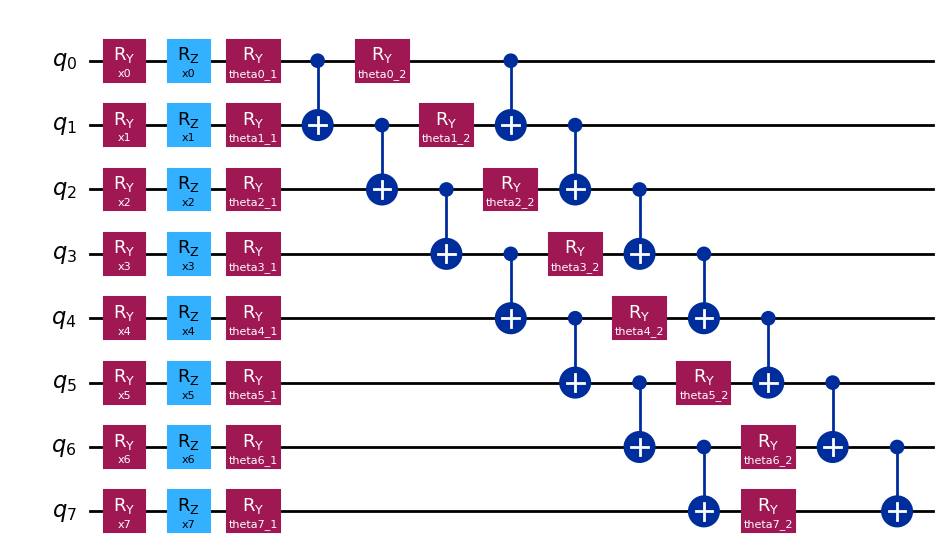

In [22]:
qc.draw(output='mpl')

## 🏗️ Quantum Neural Network (QNN) Construction

In this step, we transform the parameterized quantum circuit (PQC) into a **trainable quantum neural network** that can interface with PyTorch.

### 🔹 Key Components
- **Backend Simulator:**  
  We use `AerSimulator` with the **statevector method** to simulate the quantum circuit on a classical machine.
- **Estimator:**  
  `EstimatorV2` evaluates expectation values of the specified observables for given input and trainable parameters.
- **Gradient Computation:**  
  The **parameter-shift rule** is used to compute gradients for all trainable parameters:
  - For each parameter θ, evaluate the circuit twice: θ + π/2 and θ − π/2.
  - The difference gives the gradient w.r.t. that parameter.
- **EstimatorQNN:**  
  Combines the circuit, estimator, input parameters, weight parameters, and observables into a QNN object.
- **TorchConnector:**  
  Bridges the QNN with PyTorch, allowing seamless integration of the quantum layer into a hybrid classical-quantum model.

### ⚡ Output
- `qnn`: The QNN object for quantum computations and gradient evaluation.
- `qnn_torch`: A PyTorch-compatible module that can be used as a layer in the hybrid neural network.


In [23]:
def build_qnn(qc, x_params, theta_params, observables):
    backend = AerSimulator(method='statevector')  # Quantum simulator backend
    estimator = EstimatorV2(mode=backend)         # Evaluates circuit expectation values

    # Gradient computation using the parameter-shift rule
    # For each trainable parameter, the circuit is evaluated twice:
    # once with the parameter shifted +pi/2, once with -pi/2, then the difference gives the gradient
    gradient = ParamShiftEstimatorGradient(estimator)

    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=x_params,
        weight_params=theta_params,
        observables=observables,
        gradient=gradient
    )

    qnn_torch = TorchConnector(qnn)  # Link the QNN with PyTorch for hybrid training
    return qnn, qnn_torch

qnn, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

## 🧬 Hybrid Quantum-Classical Model

In this section, we define the **Hybrid Neural Network** architecture. This model pipelines the quantum feature extractor into classical dense layers to perform the final binary classification.

### 🔹 Model Architecture
1.  **Quantum Layer (`qlayer`)**
    * **Input:** Accepts the batch of 8 normalized clinical features.
    * **Output:** Returns a **single expectation value** (scalar) per sample, representing the collapsed quantum state.
    * *Role:* Acts as a trainable, non-linear feature extractor.

2.  **Classical Hidden Layer (`hidden`)**
    * **Transformation:** Expands the single quantum output into **8 hidden neurons** (`nn.Linear(1, 8)`).
    * **Activation:** Applies **ReLU** to introduce classical non-linearity and filter negative signals.

3.  **Output Layer (`fc`)**
    * **Transformation:** Compresses the 8 hidden features down to **1 output logit** (`nn.Linear(8, 1)`).
    * *Role:* Produces the final raw score used to predict the presence of heart disease (Binary Classification).

### ⚡ Training Setup
* **Loss Function:** `BCEWithLogitsLoss` (Binary Cross-Entropy). This is numerically stable as it combines a Sigmoid layer and the BCELoss in one class.
* **Optimizer:** **Adam** optimizer is used for adaptive learning rates.
* **Weight Initialization:** Classical weights are initialized from a uniform distribution $[-0.1, 0.1]$ to ensure stable starting gradients.

In [24]:
class HybridModel(nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer
        
        # Classical layers:
        # 1. Expand the single quantum output to 8 classical neurons
        self.hidden = nn.Linear(1, 8) 
        
        # 2. Output layer: 8 neurons -> 1 binary logit
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8, 1)

        # Initialize weights for stability
        torch.nn.init.uniform_(self.hidden.weight, -0.1, 0.1)
        torch.nn.init.uniform_(self.fc.weight, -0.1, 0.1)

    def forward(self, x):
        # 1. Quantum Pass
        # x shape: (batch, 8) -> qlayer(x) shape: (batch, 1)
        x = self.qlayer(x) 
        
        # Ensure x is explicitly 2D: (batch, 1) before the classical layers
        if x.dim() == 1:
            x = x.unsqueeze(1) 
            
        # 2. Classical Pass
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Instantiate the model
model = HybridModel(qlayer=qnn_torch)

# Training Configuration
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 🏋️ Training the Hybrid Model

We train the hybrid quantum-classical model using mini-batch gradient descent. The optimization updates both the **quantum parameters** ($\theta$) and the **classical weights** simultaneously.

### 🔹 Training Procedure
1. **Epoch Loop**: We iterate through the dataset for a defined number of `EPOCHS`.
2. **Batch Processing**:
   - We use `tqdm` to display a real-time progress bar for each batch.
   - **Forward Pass**: The inputs flow through the quantum circuit (feature extraction) and classical layers (classification).
   - **Loss Computation**: We calculate the error using the criterion (BCEWithLogitsLoss).
   - **Backpropagation**: Gradients are propagated back through the classical layers and then through the quantum circuit (via the parameter-shift rule).
   - **Optimization**: The `Adam` optimizer updates all trainable parameters.
3. **Metric Tracking**:
   - **Predictions**: Raw logits are converted to probabilities via **Sigmoid** and thresholded at **0.5** to determine the class (0 or 1).
   - **Accuracy**: We track the percentage of correct predictions per epoch.
   - **Loss**: We calculate the average loss over the entire dataset.
4. **Logging**: Summary statistics are printed every `LOG_INTERVAL` epochs to monitor convergence.

In [ ]:
# Lists to store metrics for visualization
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # Create a progress bar for the current epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for batch_x, batch_y in loop:
        batch_x = batch_x.float()

        # 1. Zero Gradients
        optimizer.zero_grad()

        # 2. Forward Pass
        outputs = model(batch_x)
        
        # 3. Calculate Loss
        loss = criterion(outputs, batch_y)
        
        # 4. Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        # 5. Track Metrics
        epoch_loss += loss.item() * batch_x.size(0)

        # Convert logits -> probabilities -> binary class (0 or 1)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)

        # Update progress bar
        loop.set_postfix(loss=epoch_loss / total, acc=correct / total)

    # Calculate average loss and accuracy for the epoch
    epoch_loss /= total
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Log progress
    if LOG_INTERVAL is not None and (epoch + 1) % LOG_INTERVAL == 0:
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Accuracy={epoch_acc:.4f}")

### 💾 Saving Trained Model and Metrics

After training, we save the **hybrid model parameters** and **training metrics** for future evaluation or reuse, based on the chosen encoding.

### ⚡ Saving Procedure
1. **Model Weights:** saved with `torch.save(model.state_dict(), model_path)`.  
2. **Training Metrics:** loss and accuracy per epoch saved with `np.save(metrics_path, [train_losses, train_accuracies])`.

This ensures **experiment reproducibility** and allows later comparison between plain and richer encodings.

In [13]:
if USE_RICHER_ENCODING:
    model_path = RICH_ENCODING_MODEL_PATH
    metrics_path = RICH_ENCODING_METRICS_PATH
else:
    model_path = PLAIN_ENCODING_MODEL_PATH
    metrics_path = PLAIN_ENCODING_METRICS_PATH

torch.save(model.state_dict(), model_path)
np.save(metrics_path, [train_losses, train_accuracies])

## 🧪 Model Evaluation & Visualization

In this section, we first **set up the evaluation environment** by loading the trained hybrid quantum-classical models (plain and richer encoding) and retrieving the previously saved **training metrics** (losses and accuracies).  

With the models and metrics ready, we perform a comprehensive evaluation and visualization.

### ⚡ What We Do Here
- **Setup & Retrieval:**  
  - Load both hybrid models using `load_hybrid_model`.  
  - Organize them in a dictionary for easy iteration.  
  - Load saved training metrics (losses and accuracies) for plotting and comparison.

- **Training Performance:**  
  - Plot **loss and accuracy curves** for plain vs richer encoding.

- **Test Set Evaluation:**  
  - Compute test accuracy, **confusion matrices**, and **classification reports**.

- **Model Internals Visualization:**  
  - Inspect **quantum layer outputs**.  
  - Compute and visualize **feature saliency maps**.  
  - Analyze **latent embeddings** via PCA.

- **Parameter Sensitivity:**  
  - Examine gradients of trainable parameters to assess their influence on predictions.
 
* **Explainability & Interpretability Metrics:**

  * **Feature Saliency / Average Feature Sensitivity** → highlights which input features most influence model outputs.
  * **Sparseness (L1/L2 ratio)** → quantifies how concentrated or diffuse the saliency map is.
  * **Saliency Entropy** → measures how spread out the saliency values are across features.
  * **Deletion Metric / Fidelity** → tests if removing top-salient features reduces true-class probability.
  * **Bug / Overreliance Detection** → compares saliency for correct vs incorrect predictions to detect misalignment or potential model bias.
  * **Minimum Efficacy** → evaluates if saliency provides information beyond raw model confidence.
  * **Overreliance Risk** → correlation between confidence and fidelity to check if explanations could mislead humans by overstating certainty.

- **Statistical Testing:**  
  - Use the **Wilcoxon signed-rank test** to quantify differences in feature importance between plain and richer encoding.
 
### ⚠️ Note on Classical vs Quantum Metrics

Most of the metrics above are **classical interpretability metrics**, widely established in XAI literature.

* This is because **quantum-specific explainability metrics are still scarce**, and the field lacks standardized methods for analyzing hybrid quantum-classical models.
* Using classical metrics allows us to **evaluate and compare the hybrid models in a rigorous and interpretable way**, even though part of the model is quantum.

In [26]:
def load_hybrid_model(richer_encoding: bool, saved_model_path: str):
    global USE_RICHER_ENCODING
    original_flag = USE_RICHER_ENCODING
    USE_RICHER_ENCODING = richer_encoding

    # Build quantum circuit
    qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

    # Build QNN and Torch connector
    _, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

    # Create model and attach the quantum layer
    model = HybridModel(qnn_torch)

    # Load saved weights
    model.load_state_dict(torch.load(saved_model_path))
    model.eval()

    # Restore the original flag
    USE_RICHER_ENCODING = original_flag
    return model

# Load trained hybrid models for both encoding types
model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)

# Organize models in a dictionary for convenience
models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

# Load previously saved training metrics (losses and accuracies)
plain_losses, plain_acc = np.load(PLAIN_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)
rich_losses, rich_acc   = np.load(RICH_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)

### 📈 Training Loss and Accuracy Comparison

This plot shows the **training performance** of the hybrid models for both **plain** and **richer encoding** schemes.

- **Left Plot — Training Loss:**  
  Visualizes how the cross-entropy loss decreases over epochs for each model. Lower values indicate better learning.

- **Right Plot — Training Accuracy:**  
  Shows the proportion of correctly classified training samples per epoch. Higher values indicate better model performance.

By comparing these curves, we can see the **impact of richer encoding** on learning speed and stability.

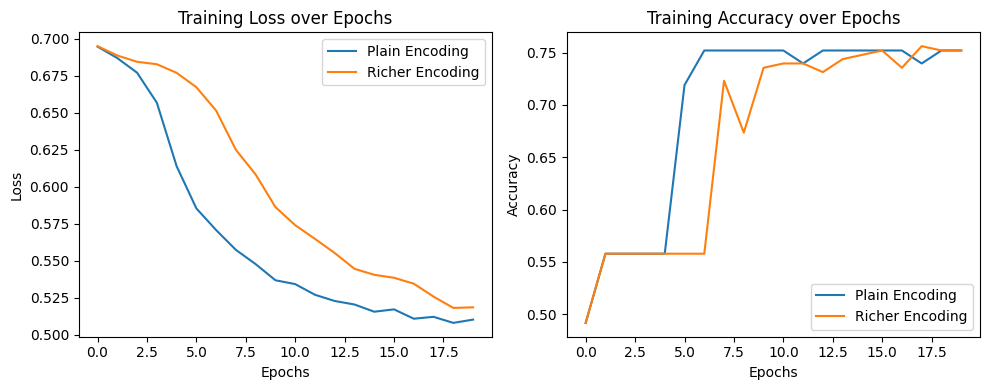

In [27]:
plt.figure(figsize=(10,4))

# Training Loss
plt.subplot(1,2,1)
plt.plot(plain_losses, label="Plain Encoding")
plt.plot(rich_losses, label="Richer Encoding")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

# Training Accuracy
plt.subplot(1,2,2)
plt.plot(plain_acc, label="Plain Encoding")
plt.plot(rich_acc, label="Richer Encoding")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.show()

### 📊 Classification Reports

This section provides **detailed evaluation metrics** for each model on the test set:

- **Precision:** proportion of correct positive predictions per class.  
- **Recall:** proportion of actual positives correctly identified per class.  
- **F1-score:** harmonic mean of precision and recall.  
- **Support:** number of samples for each class.  

Comparing the reports for **plain vs richer encoding** helps identify which Iris species each model classifies better or struggles with.

In [28]:
for name, mdl in models.items():
    with torch.no_grad():
        outputs = mdl(X_test)                     # Forward pass
        preds = (torch.sigmoid(outputs) >= 0.5).int()  # Threshold at 0.5 for binary

    # Convert tensors to NumPy for sklearn
    y_true = y_test.numpy()
    y_pred = preds.numpy()

    # Print detailed classification metrics
    print(f"\n{name} Classification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["No", "Yes"]  # Binary class labels
    ))


Plain Encoding Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.93      0.83        29
         Yes       0.92      0.72      0.81        32

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.84      0.82      0.82        61


Richer Encoding Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.93      0.84        29
         Yes       0.92      0.75      0.83        32

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



### 🧩 Test Accuracy and Confusion Matrices

In this section, we **evaluate the trained hybrid models** on the test set and visualize their performance.

- **Test Accuracy:**  
  Prints the overall accuracy for each model (plain vs richer encoding).

- **Confusion Matrices:**  
  Show how well each model predicts each Iris species.  
  - Diagonal values: correctly classified samples  
  - Off-diagonal values: misclassifications  

This visualization allows quick comparison of **classification strengths and weaknesses** between the two encoding approaches.

Plain Encoding - Test Accuracy: 0.8197
Richer Encoding - Test Accuracy: 0.8361


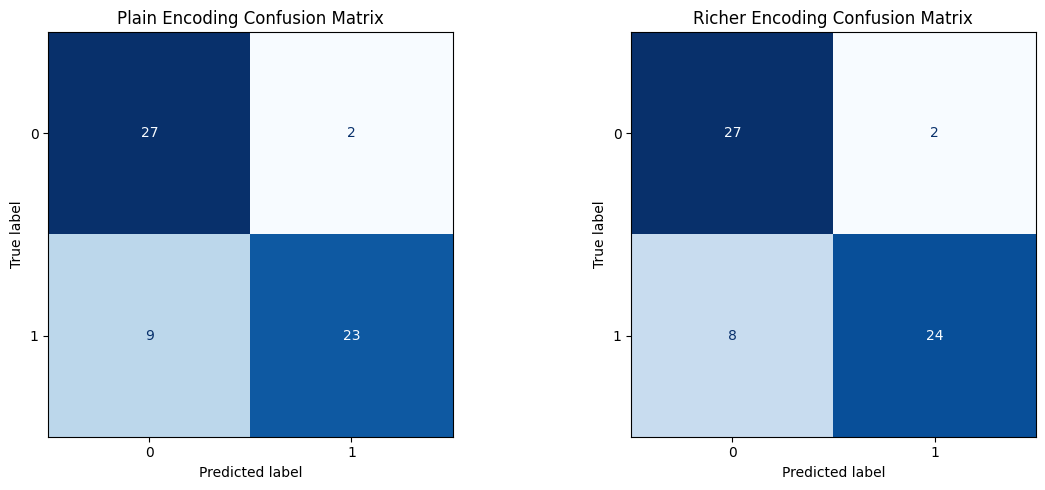

In [24]:
plt.figure(figsize=(12, 5))

for i, (name, mdl) in enumerate(models.items()):
    with torch.no_grad():  # Disable gradients for evaluation
        outputs = mdl(X_test)  # Forward pass

        # For BCEWithLogitsLoss (single output), threshold at 0.5
        preds = (torch.sigmoid(outputs) >= 0.5).int()  

        # Compute test accuracy
        test_acc = (preds == y_test.int()).float().mean().item()
        print(f"{name} - Test Accuracy: {test_acc:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_test.numpy(), preds.numpy())
        plt.subplot(1, len(models), i+1)  # Correct subplot positioning
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

### Accuracy across seeds

### 🔍 Feature Saliency Analysis

This section analyzes **how sensitive the model outputs are to each input feature**:

- **Saliency Maps:**  
  - Computed using a finite difference method: perturb each feature slightly and observe the change in output.  
  - Rows = test samples, columns = features.  
  - Color intensity indicates how strongly the model output responds to that feature.

- **Average Feature Saliency:**  
  - Aggregates the saliency values across all samples for each feature.  
  - Bar plots allow direct comparison of **plain vs richer encoding** models.  

Insights:  
- Features with higher saliency are more important for the model’s decision.  
- Differences between plain and richer encoding indicate how the extra RZ rotations influence feature representation.

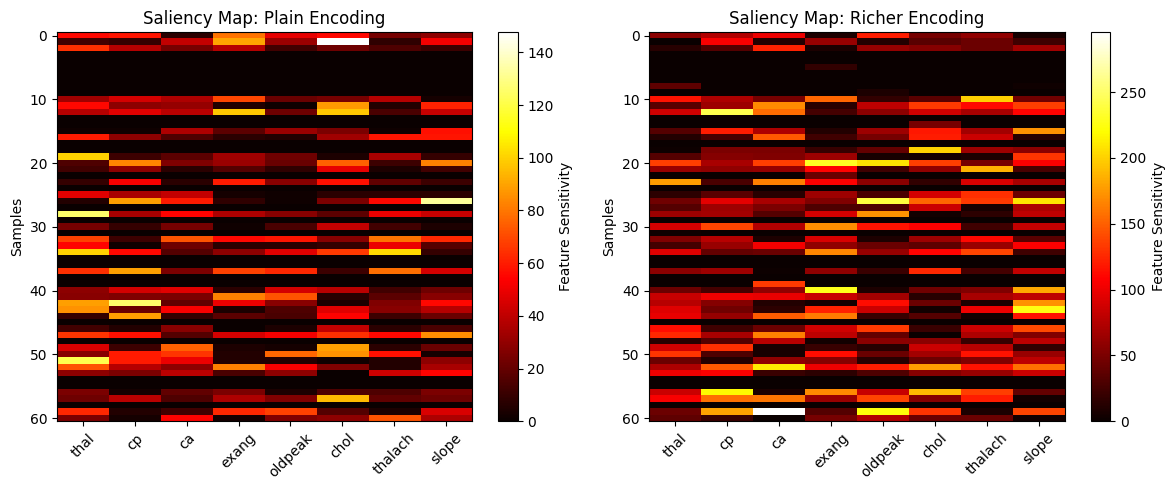

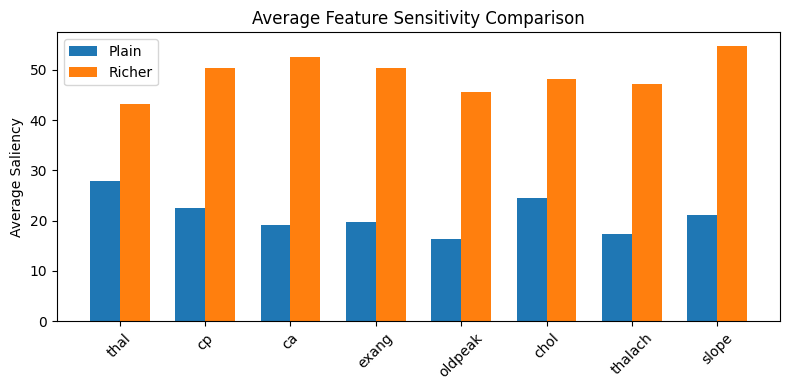

In [32]:
def compute_saliency(model, inputs, delta=1e-3):
    model.eval()
    inputs = inputs.clone().detach()
    base_output = model(inputs).detach().numpy()
    saliency = np.zeros_like(inputs)

    for feature_idx in range(inputs.shape[1]):
        perturbed = inputs.clone()
        perturbed[:, feature_idx] += delta
        perturbed_output = model(perturbed).detach().numpy()
        grad_estimate = (perturbed_output - base_output) / delta
        if grad_estimate.ndim > 1:
            saliency[:, feature_idx] = np.mean(np.abs(grad_estimate), axis=1)
        else:
            saliency[:, feature_idx] = np.abs(grad_estimate)
    
    return saliency

saliency_plain = compute_saliency(model_plain, X_test)
saliency_rich  = compute_saliency(model_rich, X_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(saliency_plain, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Plain Encoding")
plt.xticks(range(X_test.shape[1]), TOP_8_FEATS, rotation=45)
plt.ylabel("Samples")

plt.subplot(1,2,2)
plt.imshow(saliency_rich, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Richer Encoding")
plt.xticks(range(X_test.shape[1]), TOP_8_FEATS, rotation=45)
plt.ylabel("Samples")

plt.tight_layout()
plt.show()

mean_plain = saliency_plain.mean(axis=0)
mean_rich  = saliency_rich.mean(axis=0)

plt.figure(figsize=(8,4))
x = np.arange(len(TOP_8_FEATS))
width = 0.35
plt.bar(x - width/2, mean_plain, width, label="Plain")
plt.bar(x + width/2, mean_rich, width, label="Richer")
plt.xticks(x, TOP_8_FEATS, rotation=45)
plt.ylabel("Average Saliency")
plt.title("Average Feature Sensitivity Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### 🧪 Average Sensitivity (Stability of Explanations)

This section evaluates **how stable the model’s saliency explanations are** under small perturbations of the input.

* **Purpose:**
  Average Sensitivity measures whether tiny random changes to the input cause large changes in the saliency values.
  A good explanation method should be **stable** e.g. small input noise should not radically alter which features appear important.

* **Method:**

  1. Compute the original saliency map for the model.
  2. Add a very small random perturbation (Gaussian noise scaled by `δ`) to each input sample.
  3. Recompute the saliency on the perturbed input.
  4. Measure the **mean absolute difference** between the two saliency maps.

* **Interpretation:**

  * **Low Average Sensitivity** -> robust, stable explanations.
  * **High Average Sensitivity** -> explanations are fragile and inconsistent.
  * Comparing values for **plain** vs **richer encoding** reveals whether the richer architecture produces more reliable feature attributions.

This metric helps ensure that saliency-based explanations are not just accurate but also **consistent**, which is critical for human trust and interpretability.

In [33]:
def average_sensitivity(model, inputs, delta=1e-3, saliency_fn=compute_saliency):
    # Original saliency
    saliency_orig = saliency_fn(model, inputs, delta)
    
    # Add small random noise to inputs
    noise = torch.randn_like(inputs) * delta
    inputs_perturbed = inputs + noise
    
    # Saliency for perturbed inputs
    saliency_perturbed = saliency_fn(model, inputs_perturbed, delta)
    
    # Compute average absolute difference
    avg_sens = np.mean(np.abs(saliency_orig - saliency_perturbed))
    return avg_sens

avg_sens_plain = average_sensitivity(model_plain, X_test)
avg_sens_rich  = average_sensitivity(model_rich, X_test)

print("Average Sensitivity (Plain):", avg_sens_plain)
print("Average Sensitivity (Richer):", avg_sens_rich)

Average Sensitivity (Plain): 22.517754
Average Sensitivity (Richer): 39.548725


### Feature importance across seeds

### Saliency rank stability

### Grad x Input (normalized)

### Integrated Gradients (normalized)

### SmoothGrad

### Global Feature Importance

### ✂️ Deletion Metric (Faithfulness of Saliency)

The **Deletion Metric** evaluates **how faithfully the saliency map reflects the model’s true decision process**.

* **Purpose:**
  If a saliency method correctly identifies the most important features, then **removing those features should significantly reduce the model's confidence** in the true class.

* **Method:**

  1. Rank features for each sample by saliency (highest -> lowest importance).
  2. Iteratively delete the top-*k* most salient features by setting them to zero.
  3. Measure how much the model’s **true-class probability** decreases as more salient features are removed.
  4. Repeat for *k = 1 … 5* and average across the dataset.

* **Interpretation:**

  * A **good saliency method** produces a **steep deletion curve** e.g. removing the “most important” features should sharply reduce confidence.
  * A **flat curve** indicates that the saliency does **not** correspond to the real decision-making process.
  * Comparing deletion curves for the **plain** vs **richer encoding** models reveals which one depends more transparently on its salient features.

* **Observed Behavior (Important Insight):**
  In our case:

  * **Plain Encoding:** Confidence drops sharply from ~0.38 to 0.21 after removing the top 1–2 features, then stabilizes around ~0.30 for *k = 3–5*.
  * **Richer Encoding:** Confidence starts higher (~0.50), drops to ~0.34 for k=2, reaches ~0.25 for k=3, then stabilizes around ~0.30 for k=4–5.

  This indicates that:

  * Both models rely primarily on the **top 1-2 features**.
  * Once the key features are removed, additional deletions do **not** significantly affect confidence.
  * The richer model’s top features are slightly more informative individually (higher initial confidence), but both models show a plateau after removing the most important features.

  This is a **desirable behavior**, showing that the saliency maps faithfully identify the features most critical for the model’s predictions, and once removed, the models fall back to near-baseline confidence.

* **Visualization:**
  The plot shows:

  * **x-axis:** number of removed top-salient features
  * **y-axis:** remaining probability for the true class

  A model with more faithful saliency explanations will have a **more rapidly decreasing** curve, especially in the first 1–2 feature removals, before stabilizing as the remaining features carry little additional information.

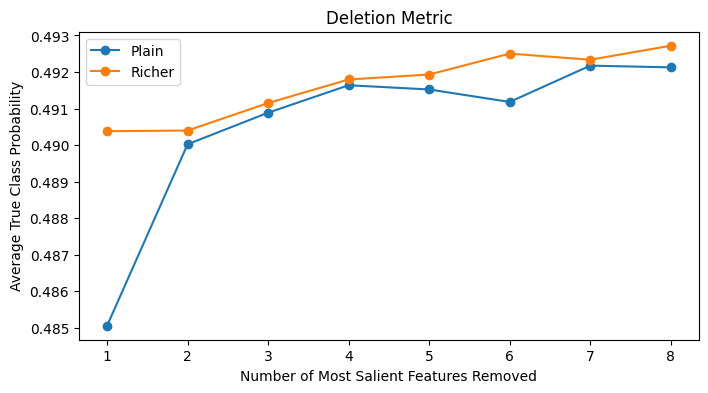

In [37]:
def deletion_score(model, inputs, labels, saliency, steps=5):
    inputs_copy = inputs.clone()
    labels_np = labels.numpy()
    scores = []

    for k in range(1, steps+1):
        topk = np.argsort(-saliency, axis=1)[:, :k]
        modified = inputs_copy.clone()
        
        for i in range(modified.shape[0]):
            modified[i, topk[i]] = 0.0
        
        with torch.no_grad():
            outputs = model(modified)  # shape (n_samples, 1)
            probs = torch.sigmoid(outputs).numpy().flatten()  # probability of class 1
            true_class_probs = np.where(labels_np==1, probs, 1-probs)
        
        scores.append(true_class_probs.mean())
    
    return scores

labels_test = y_test.clone().detach().long()
deletion_plain = deletion_score(model_plain, X_test, labels_test, saliency_plain, steps=X_test.shape[1])
deletion_rich  = deletion_score(model_rich, X_test, labels_test, saliency_rich, steps=X_test.shape[1])

plt.figure(figsize=(8,4))
plt.plot(range(1, X_test.shape[1]+1), deletion_plain, marker='o', label="Plain")
plt.plot(range(1, X_test.shape[1]+1), deletion_rich, marker='o', label="Richer")
plt.xlabel("Number of Most Salient Features Removed")
plt.ylabel("Average True Class Probability")
plt.title("Deletion Metric")
plt.legend()
plt.show()

### Occlusion delta-loss

### 📈 Minimum Efficacy (Saliency Beyond Confidence)

The **Minimum Efficacy** metric evaluates **whether saliency maps provide additional explanatory power beyond the model’s raw confidence**, ensuring that explanations are meaningful even when predictions are highly confident.

* **Purpose:**

  * Saliency maps should highlight **which features drive predictions**, not just reflect the model’s confidence.
  * A faithful saliency method increases **trust and interpretability**, while low or misleading efficacy could overemphasize confidence rather than true feature importance.

* **Method:**

  1. Compute **predictions** and a correctness vector:

     * `1` → correct prediction
     * `0` → incorrect prediction

     ```python
     correct = (preds == labels).astype(int)
     ```

  2. Compute **baseline confidence** per sample:

     * Maximum probability assigned by the model to any class.

  3. Compute **saliency signal**:

     * Mean absolute saliency per sample.

  4. Calculate **ROC AUC** for:

     * Confidence vs correctness
     * Saliency vs correctness

  5. **Saliency Gain** = `AUC(saliency) - AUC(confidence)`

     * Positive → saliency provides additional discriminative power beyond confidence
     * Negative → saliency adds little or potentially misleading information

* **Implementation Note:**

  * If the test set contains only **one class in the correctness vector**, ROC AUC is undefined. In such cases, the metric returns `nan` instead of raising a warning.

* **Observed Results:**

```
--- Plain Encoding ---
AUC (Confidence) : nan
AUC (Saliency)   : nan
Saliency Gain    : nan

--- Richer Encoding ---
AUC (Confidence) : 1.0000
AUC (Saliency)   : 0.8621
Saliency Gain    : -0.1379
```

* **Interpretation:**

  * **Plain Encoding:**

    * `nan` indicates that the correctness vector contained only **one class** — all predictions were either correct or incorrect.
    * This is **informative about the model**: it is very consistent and confident.
    * Since there is no variation in correctness, saliency efficacy **cannot be evaluated** via ROC AUC, but the behavior itself highlights the model’s uniform decision pattern.

  * **Richer Encoding:**

    * Confidence AUC = 1.0 → the model predicts correctly with **perfect confidence**.
    * Saliency AUC = 0.8621 → saliency is **informative but not perfectly aligned** with correctness.
    * Saliency Gain = -0.1379 → saliency adds slightly less discriminative power than raw confidence alone.

  * **Overall Insight:**

    * Minimum Efficacy reveals **differences in both model behavior and saliency quality**.
    * `nan` values can be **meaningful**, indicating highly consistent predictions, not just missing data.
    * Negative saliency gain shows that even when predictions are confident, saliency maps may **underrepresent certain important features**, pointing to potential areas for improving explanation fidelity.

In [54]:
def safe_roc_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return float('nan')
    return roc_auc_score(y_true, y_score)

def minimum_efficacy(model, inputs, labels, saliency):
    with torch.no_grad():
        # Ensure outputs is 1D array (Length N)
        outputs = model(inputs).detach().cpu().numpy().ravel()
        probs = torch.sigmoid(torch.tensor(outputs)).numpy()
        
    # Ensure labels_np is 1D array (Length N)
    labels_np = labels.detach().cpu().numpy().ravel() if torch.is_tensor(labels) else np.asarray(labels).ravel()

    # Predictions (Length N)
    preds = (probs >= 0.5).astype(int)

    # Correctness indicator (Length N)
    correct = (preds == labels_np).astype(int)
    
    # Confidence in prediction (Length N)
    pred_conf = np.where(preds == 1, probs, 1 - probs)

    # Ensure all final inputs are flattened one last time (though should be 1D here)
    correct = correct.ravel()
    pred_conf = pred_conf.ravel()

    # Check for consistency just before calling AUC to prevent the ValueError
    if len(correct) != len(pred_conf):
        raise ValueError(f"Inconsistent sample lengths: correct={len(correct)}, pred_conf={len(pred_conf)}")

    # Proceed with AUC calculation
    auc_conf = safe_roc_auc(correct, pred_conf)
    
    # Saliency part: Ensure saliency is correctly mean-reduced to length N
    # saliency.mean(axis=1) must have length N (i.e., the batch size)
    auc_sal = safe_roc_auc(correct, saliency.mean(axis=1).ravel())

    sal_gain = auc_sal - auc_conf if not (np.isnan(auc_conf) or np.isnan(auc_sal)) else float('nan')
    return {"auc_confidence": auc_conf, "auc_saliency": auc_sal, "saliency_gain": sal_gain}

min_eff_plain = minimum_efficacy(model_plain, X_test, y_test, saliency_plain)
min_eff_rich  = minimum_efficacy(model_rich, X_test, y_test, saliency_rich)

def print_min_eff(name, result):
    print(f"--- {name} ---")
    print(f"AUC (Confidence) : {result['auc_confidence']:.4f}" if not np.isnan(result['auc_confidence']) else "AUC (Confidence) : nan")
    print(f"AUC (Saliency)   : {result['auc_saliency']:.4f}"   if not np.isnan(result['auc_saliency']) else "AUC (Saliency)   : nan")
    print(f"Saliency Gain    : {result['saliency_gain']:.4f}"   if not np.isnan(result['saliency_gain']) else "Saliency Gain    : nan\n")

print_min_eff("Plain Encoding", min_eff_plain)
print_min_eff("Richer Encoding", min_eff_rich)

--- Plain Encoding ---
AUC (Confidence) : 0.8309
AUC (Saliency)   : 0.3036
Saliency Gain    : -0.5273
--- Richer Encoding ---
AUC (Confidence) : 0.7324
AUC (Saliency)   : 0.4382
Saliency Gain    : -0.2941


### ⚠️ Overreliance Risk (Reliability of Saliency Beyond Confidence)

The **Overreliance Risk** metric evaluates **whether the saliency map provides useful information beyond the model’s raw confidence**, helping to identify if users might be misled by overconfident predictions.

* **Purpose:**
  Even if a model is confident, a faithful saliency map should **highlight features that truly influence the prediction**.
  If saliency is weakly aligned with prediction changes, users could **overtrust the model**, relying on confidence alone rather than the explanation.

* **Method:**

  1. Compute **per-sample deletion fidelity**:

     * For each sample, remove the top-*k* most salient features (here *k = 1*).
     * Measure the **drop in probability** for the true class:

     $$
     \text{fidelity}*i = p*{\text{true, original}} - p_{\text{true, after deletion}}
     $$

  2. Compute the **model’s confidence** per sample:

     $$
     \text{confidence}*i = \max_j p*{i,j}
     $$

  3. Define **overreliance risk** as the correlation between confidence and **negative fidelity**:

     $$
     \text{Risk} = \text{corr}(\text{confidence}, -\text{fidelity})
     $$

     * A **positive correlation** → high confidence but weak fidelity → **high risk of misleading explanations**.
     * A **negative or near-zero correlation** → low risk → saliency correctly indicates feature importance beyond mere confidence.

* **Observed Behavior:**

  ```
  Overreliance Risk (Plain) : -0.168
  Overreliance Risk (Richer): -0.164
  ```

  * Both values are slightly negative, indicating **low risk** of users being misled by overconfident predictions.
  * The richer encoding shows similar behavior to the plain encoding, suggesting its explanations are **equally reliable** in highlighting influential features beyond model confidence.

* **Interpretation:**

  * Negative values → confident predictions generally correspond to meaningful saliency drops when top features are deleted.
  * The metric complements **Deletion Fidelity**, confirming that the saliency map is not simply reflecting the model’s raw confidence but faithfully indicates **which features truly matter**.

In [48]:
def deletion_fidelity_per_sample(model, inputs, saliency, labels, k=1):
    N, F = inputs.shape

    # ensure labels are integer tensor
    if not torch.is_tensor(labels):
        labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.to(inputs.device)

    with torch.no_grad():
        outputs = model(inputs).flatten()            # shape: (N,)
        probs = torch.sigmoid(outputs)              # probability of class 1
        base_conf = probs.cpu().numpy()             # shape: (N,)

    fidelity = np.zeros(N)

    for i in range(N):
        topk = np.argsort(-saliency[i])[:k]         # top-k features
        x_mod = inputs[i].clone()
        x_mod[topk] = 0.0

        with torch.no_grad():
            out = model(x_mod.unsqueeze(0)).flatten()
            prob = torch.sigmoid(out).item()

        # confidence drop for true class
        true_label = labels[i].item()
        if true_label == 1:
            fidelity[i] = base_conf[i] - prob
        else:
            fidelity[i] = (1 - base_conf[i]) - (1 - prob)

    return fidelity


def overreliance_risk(confidence, fidelity):
    return np.corrcoef(confidence, -fidelity)[0, 1]


# --- Compute fidelity ---
fidelity_plain = deletion_fidelity_per_sample(model_plain, X_test, saliency_plain, y_test, k=1)
fidelity_rich  = deletion_fidelity_per_sample(model_rich,  X_test, saliency_rich,  y_test, k=1)

# --- Compute confidence per sample ---
with torch.no_grad():
    conf_plain = torch.sigmoid(model_plain(X_test).flatten()).cpu().numpy()
    conf_rich  = torch.sigmoid(model_rich(X_test).flatten()).cpu().numpy()

# --- Compute overreliance risk ---
risk_plain = overreliance_risk(conf_plain, fidelity_plain)
risk_rich  = overreliance_risk(conf_rich, fidelity_rich)

print("Overreliance Risk (Plain):", risk_plain)
print("Overreliance Risk (Rich):",  risk_rich)

Overreliance Risk (Plain): -0.5382887524849577
Overreliance Risk (Rich): -0.5357716801228966


### Noise sensitivity (normalized)

### 📊 Saliency Entropy (Complexity of Explanations)

The **Saliency Entropy** metric measures **how spread out or concentrated the feature importance is across input features**, providing a complementary view to sparsity.

* **Purpose:**
  Entropy captures the **overall complexity** of the saliency distribution:

  * Low entropy → most importance is concentrated on a few features → simple and concise explanations
  * High entropy → importance is spread across many features → more complex and potentially harder to interpret explanations

* **Method:**

  1. Compute the **mean saliency** for each feature across all samples.
  2. Normalize to get a probability distribution.
  3. Compute the **Shannon entropy** of this distribution:

  $$
  H = - \sum_i p_i \log(p_i)
  $$

* **Interpretation:**

  * **Low entropy** → explanations are focused, highlighting a few key features.
  * **High entropy** → explanations are distributed, indicating the model relies on multiple features or has entangled representations.
  * Comparing **plain** vs **richer encoding** models shows which produces simpler, more concise explanations. As we can observe, while the entropies are similar, the plain encoding produces a lower entropy and thus leading to a simpler and more concise explanation.

In [40]:
from scipy.stats import entropy

def saliency_entropy(saliency):
    mean_sal = saliency.mean(axis=0)
    p = mean_sal / (mean_sal.sum() + 1e-12)
    return entropy(p)

entropy_plain = saliency_entropy(saliency_plain)
entropy_rich  = saliency_entropy(saliency_rich)

print("Entropy (Plain):", entropy_plain)
print("Entropy (Richer):", entropy_rich)

Entropy (Plain): 2.065228
Entropy (Richer): 2.0769086


### 🧩 Saliency Sparseness (Conciseness of Explanations)

The **Saliency Sparseness** metric evaluates **how concentrated or distributed the saliency values are across input features**.

* **Purpose:**
  A sparse explanation highlights a **small number of highly important features**, which can improve interpretability and make explanations easier for humans to understand.
  Conversely, a dense explanation spreads importance across many features, making it harder to discern which features truly matter.

* **Method:**

  1. Compute the **L1 norm** of the saliency map (sum of absolute values).
  2. Compute the **L2 norm** of the saliency map (square root of sum of squares).
  3. Define sparsity as:

$$
\text{Sparsity} = \frac{||\text{saliency}||_1}{||\text{saliency}||_2 + \epsilon}
$$

  * Lower values indicate **higher sparsity** (more focused explanations).
  * Higher values indicate **less sparse** explanations (spread-out feature importance).

* **Interpretation:**

  * **Low Sparseness** → the model’s saliency focuses on a few key features → easier to understand and trust.
  * **High Sparseness** → the model distributes importance across many features → may indicate redundant or entangled feature use.
  * Comparing the **plain** vs **richer encoding** models shows whether richer representations produce more concentrated or more distributed explanations. We observe that the plain encoding has a more concentrated explanation.

In [38]:
def saliency_sparseness(saliency):
    l1 = np.sum(np.abs(saliency))
    l2 = np.sqrt(np.sum(saliency**2))
    return l1 / (l2 + 1e-12)

sparse_plain = saliency_sparseness(saliency_plain)
sparse_rich  = saliency_sparseness(saliency_rich)

print("Sparseness (Plain):", sparse_plain)
print("Sparseness (Rich):", sparse_rich)

Sparseness (Plain): 13.271839
Sparseness (Rich): 14.330239


### 🧠 Quantum Embedding Visualization (PCA)

This section visualizes the **quantum layer outputs** in 2D using **Principal Component Analysis (PCA)**:

- Each point represents a test sample in the **quantum feature space**.  
- Color corresponds to the **true class** of the sample.  
- Comparing the two plots shows how the **plain vs richer encoding** affects the separation of classes:
  - **Plain Encoding:** simpler mapping, possibly more overlapping clusters.  
  - **Richer Encoding:** extra RZ rotations provide a more expressive embedding, which can lead to better class separation.  

This visualization helps intuitively understand why richer encoding may improve classification performance.

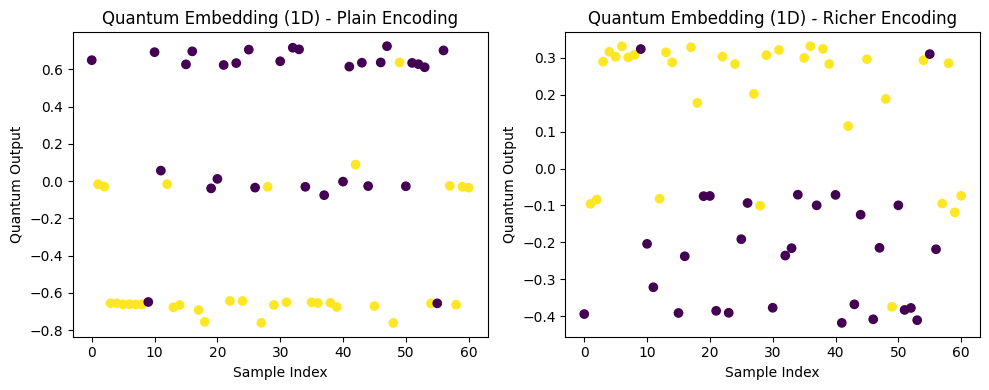

In [56]:
def visualize_latent_1d(model, name):
    with torch.no_grad():
        latent = model.qlayer(X_test).detach().cpu().numpy().flatten()  # shape: (num_samples,)
    
    y_np = y_test.detach().cpu().numpy() if torch.is_tensor(y_test) else y_test

    plt.scatter(range(len(latent)), latent, c=y_np, cmap='viridis')
    plt.title(f"Quantum Embedding (1D) - {name}")
    plt.xlabel("Sample Index")
    plt.ylabel("Quantum Output")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
visualize_latent_1d(model_plain, "Plain Encoding")
plt.subplot(1,2,2)
visualize_latent_1d(model_rich, "Richer Encoding")
plt.tight_layout()
plt.show()

### Decision surface using top-2 salient features

### Partial dependence

### ⚡ Parameter Sensitivity Analysis

This section evaluates how sensitive the model outputs are to changes in **each trainable parameter**:

- **Gradient Magnitude:**  
  - The gradient of the loss w.r.t. each parameter tensor is computed on the test set.  
  - Larger gradients indicate parameters that strongly influence the model’s predictions.

- **Purpose:**  
  - Compare **plain vs richer encoding** to see how additional quantum gates affect parameter sensitivity.  
  - Parameters with consistently higher gradients may be more important for model performance.

- **Visualization:**  
  - Each bar represents the **average absolute gradient of a full parameter tensor**, not individual weights.  
  - The hybrid model has 5 trainable tensors:
    1. QNN trainable parameters (theta)  
    2. Hidden layer weights  
    3. Hidden layer biases  
    4. Output layer weights  
    5. Output layer biases  
  - Multiple bars (side-by-side) allow direct comparison between the two models.  

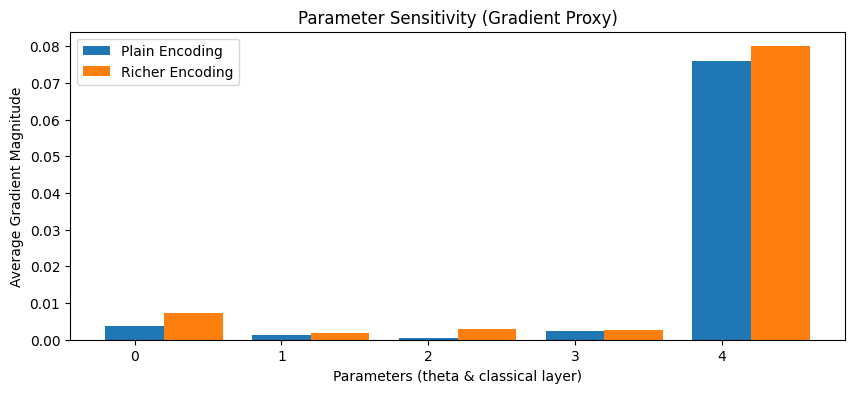

In [57]:
plt.figure(figsize=(10,4))

for i, (name, mdl) in enumerate(models.items()):
    mdl.train()  # Enable gradient computation for parameter sensitivity
    
    # Temporary optimizer for backward pass (not actually training)
    optimizer = torch.optim.Adam(mdl.parameters())
    optimizer.zero_grad()
    
    # Forward pass on the test set
    outputs = mdl(X_test)
    loss = criterion(outputs, y_test)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Collect average gradient magnitudes for each parameter
    grads = []
    for param in mdl.parameters():
        if param.requires_grad and param.grad is not None:
            grads.append(param.grad.detach().abs().mean().item())
    
    # Plot the average gradients for each parameter
    plt.bar(np.arange(len(grads)) + i*0.4, grads, width=0.4, label=name)

plt.xlabel("Parameters (theta & classical layer)")
plt.ylabel("Average Gradient Magnitude")
plt.title("Parameter Sensitivity (Gradient Proxy)")
plt.legend()
plt.show()

### Layer/operation cumulative Δ-loss

### Gate knock-out 

### 📊 Wilcoxon Test: Feature Saliency Comparison

This section statistically compares the **feature saliency** between the **plain** and **richer encoding** models using the **Wilcoxon signed-rank test**:

- **Purpose:**  
  - Determine whether adding richer quantum encoding significantly changes the sensitivity of the model to each input feature.
  
- **Procedure:**  
  1. For each feature, extract saliency values (sensitivity) from both models.  
  2. Apply the Wilcoxon signed-rank test to check for differences between the paired distributions.  
  3. Mark features with `p < 0.05` as statistically significant (`*`).

- **Interpretation:**  
  - A significant result (`*`) suggests that the feature's influence on the model output differs between plain and richer encoding.

In [59]:
print("Wilcoxon Test: Plain vs Richer Encoding Feature Saliency\n")

for feature_idx, feature_name in enumerate(TOP_8_FEATS):
    plain_vals = saliency_plain[:, feature_idx]
    rich_vals  = saliency_rich[:, feature_idx]
    
    stat, p = wilcoxon(plain_vals, rich_vals, zero_method="pratt")
    
    sig = "*" if p < 0.05 else ""
    print(f"{feature_name:10}: stat={stat:.4f}, p={p:.4f} {sig}")

Wilcoxon Test: Plain vs Richer Encoding Feature Saliency

thal      : stat=551.0000, p=0.0341 *
cp        : stat=379.0000, p=0.0012 *
ca        : stat=415.0000, p=0.0018 *
exang     : stat=293.0000, p=0.0001 *
oldpeak   : stat=312.0000, p=0.0001 *
chol      : stat=431.0000, p=0.0034 *
thalach   : stat=202.0000, p=0.0000 *
slope     : stat=245.0000, p=0.0000 *
